In [18]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


benchmark_files = [f"../output/benchmark.report.{i}.json" for i in range(1, 4)]

# Load the benchmark data
def load_benchmark_json(file):
    if not os.path.exists(file):
        print(f"File '{file}' does not exist")
        raise FileNotFoundError
    
    with open(file) as f:
        data = json.load(f)
        print(f"The file '{file}' has {len(data)} benchmarked spec entries")
        return data

In [19]:
# Extract relevant measurements into DataFrames
def load_benchmark_type_rows(file, benchmark_type):
    data = load_benchmark_json(file)
    rows = []
    for entry in data:
        measurement = entry['measurement']
        if benchmark_type in measurement:

            _is_performance = benchmark_type == 'performance'

            structure = measurement[benchmark_type]['structure']
            action = measurement[benchmark_type]['action']
            qty = measurement[benchmark_type]['qty'] if 'qty' in measurement[benchmark_type] else measurement[benchmark_type]['after']

            spec_result = measurement[benchmark_type]['time'] if _is_performance else measurement[benchmark_type]['size']
            rows.append([structure, action, qty, spec_result])
    return rows

f1 = '../output/benchmark.report.1.json'
performance_rows = load_benchmark_type_rows(f1, 'performance')
memory_rows = load_benchmark_type_rows(f1, 'memory')



The file '../output/benchmark.report.1.json' has 164 benchmarked spec entries
The file '../output/benchmark.report.1.json' has 164 benchmarked spec entries


In [40]:
base_cols = ['structure', 'action', 'qty']
memory_cols = base_cols + ['size']
performance_cols = base_cols + ['time']

# Create DataFrames
def create_df(rows, columns):
    return pd.DataFrame(rows, columns=columns)

def remove_duplicates(df):
    return df.groupby(base_cols, as_index=False).mean()

def create_dfs(file):
    if not os.path.exists(file):
        print(f"File '{file}' does not exist")
        return None, None
    
    performance_rows = load_benchmark_type_rows(file, 'performance')
    memory_rows = load_benchmark_type_rows(file, 'memory')
    performance_df = create_df(performance_rows, performance_cols)
    memory_df = create_df(memory_rows, memory_cols)  # Exclude the 'size' column
    return remove_duplicates(performance_df), remove_duplicates(memory_df)

performance_dfs = []
memory_dfs = []

for file in benchmark_files:
    performance_df, memory_df = create_dfs(file)

    if performance_df is None or memory_df is None:
        continue

    performance_dfs.append(performance_df)
    memory_dfs.append(memory_df)

print(len(performance_dfs[0]), len(memory_dfs[0]))

performance_df = pd.concat(performance_dfs)
memory_df = pd.concat(memory_dfs)

print(len(performance_df), len(memory_df))

The file '../output/benchmark.report.1.json' has 164 benchmarked spec entries
The file '../output/benchmark.report.1.json' has 164 benchmarked spec entries
File '../output/benchmark.report.2.json' does not exist
File '../output/benchmark.report.3.json' does not exist
50 50
50 50


In [41]:


# Handle duplicates by averaging
""" performance_df = performance_df.groupby(['structure', 'action', 'qty'], as_index=False).mean()
memory_df = memory_df.groupby(['structure', 'action', 'qty'], as_index=False).mean() """

# Standardize as percentages relative to the smallest qty for each action
def standardize_as_percentage(df, value_column):
    standardized_data = []
    for action in df['action'].unique():
        subset = df[df['action'] == action]
        baseline = subset.loc[subset['qty'] == subset['qty'].min(), value_column].values[0]
        if (baseline == 0):
            print(f"Warning: {action} has a baseline of 0")
            baseline = 1

        subset.loc[:, value_column] = (subset.loc[:, value_column] / baseline) * 100
        standardized_data.append(subset)
    return pd.concat(standardized_data)


performance_df = standardize_as_percentage(performance_df, 'time')
memory_df = standardize_as_percentage(memory_df, 'size')


# Merging performance and memory data
merged_df = pd.merge(performance_df, memory_df, on=base_cols, suffixes=('_time', '_memory'))

merged_df

,structure,action,qty,time,size
0,Object,addNode,0,0.000000,100.000000
1,Object,addNode,1,0.000000,109.433962
2,Object,addNode,10,0.000000,162.264151
3,Object,addNode,100,0.000000,575.471698
4,Object,addNode,1000,0.000000,4907.547170
5,Object,addNode,10000,0.000000,47273.584906
6,Tuple,addNode,0,0.000000,120.754717
7,Tuple,addNode,1,0.000000,130.188679
8,Tuple,addNode,10,0.000000,171.698113
9,Tuple,addNode,100,0.000000,596.226415


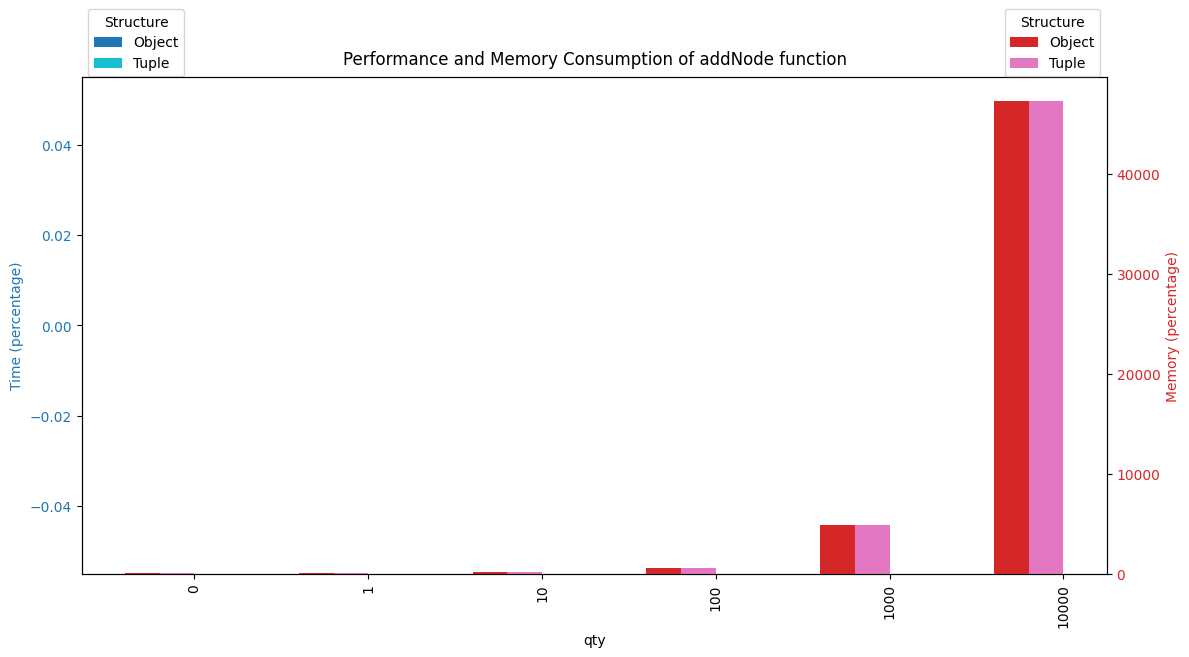

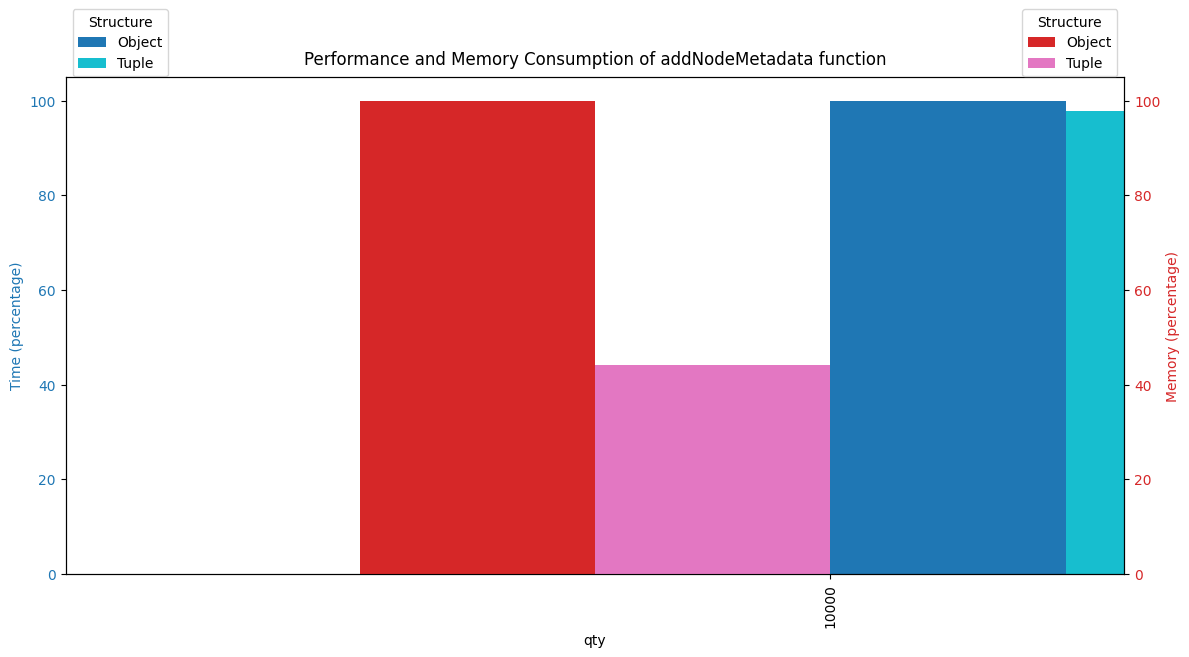

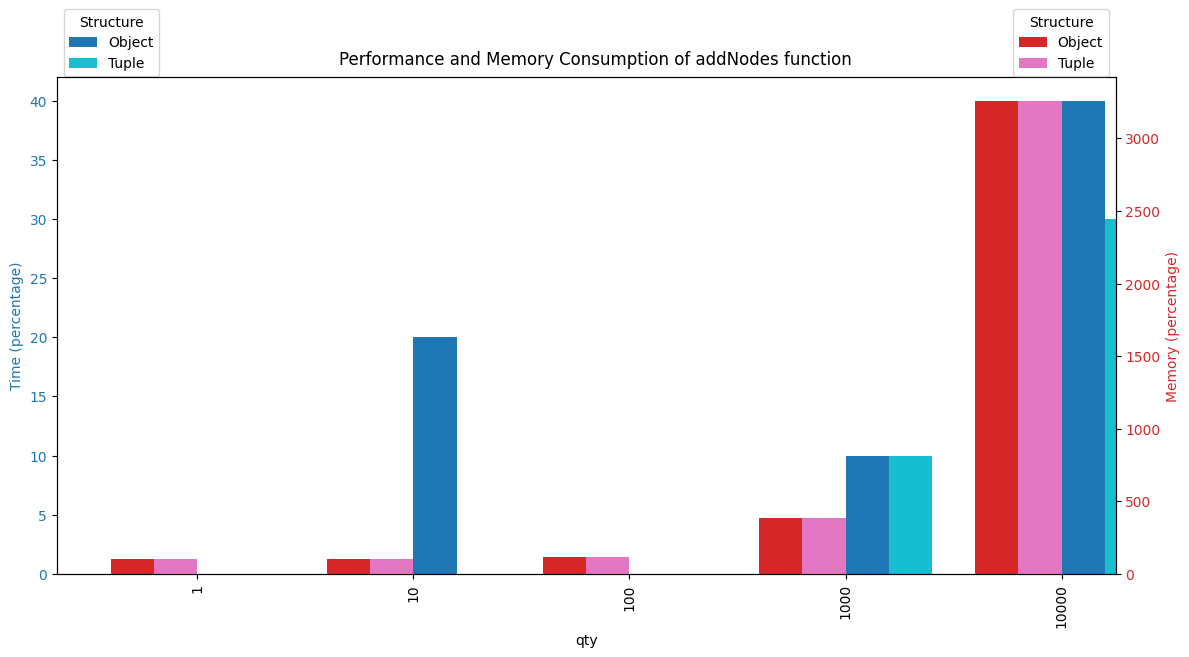

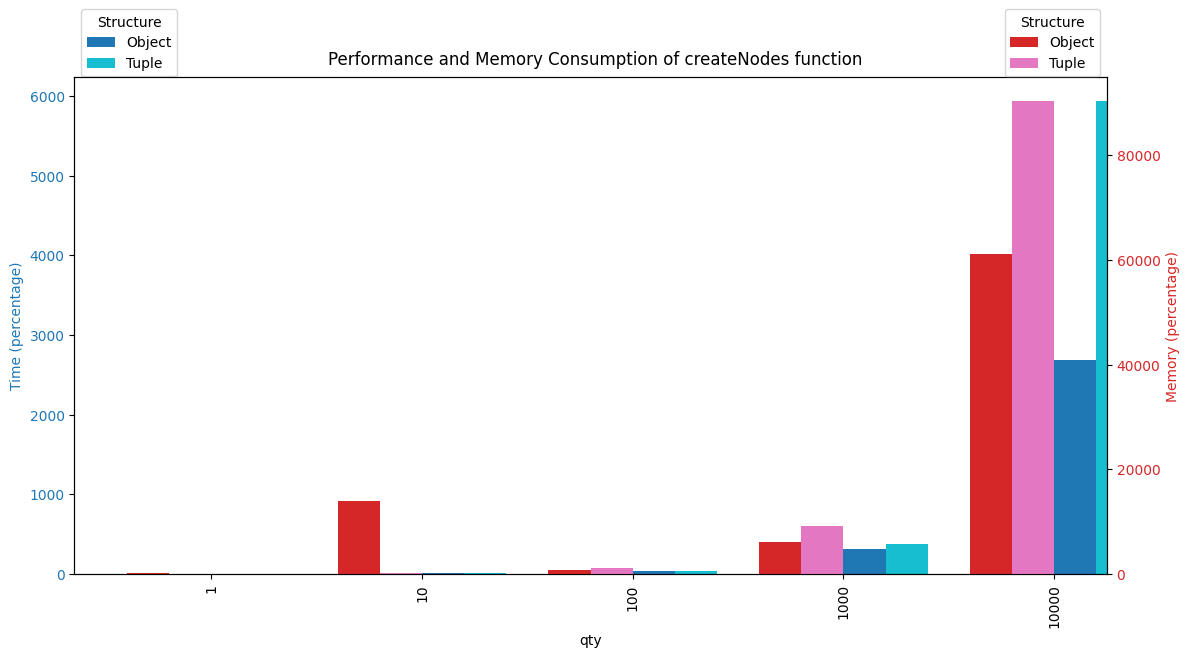

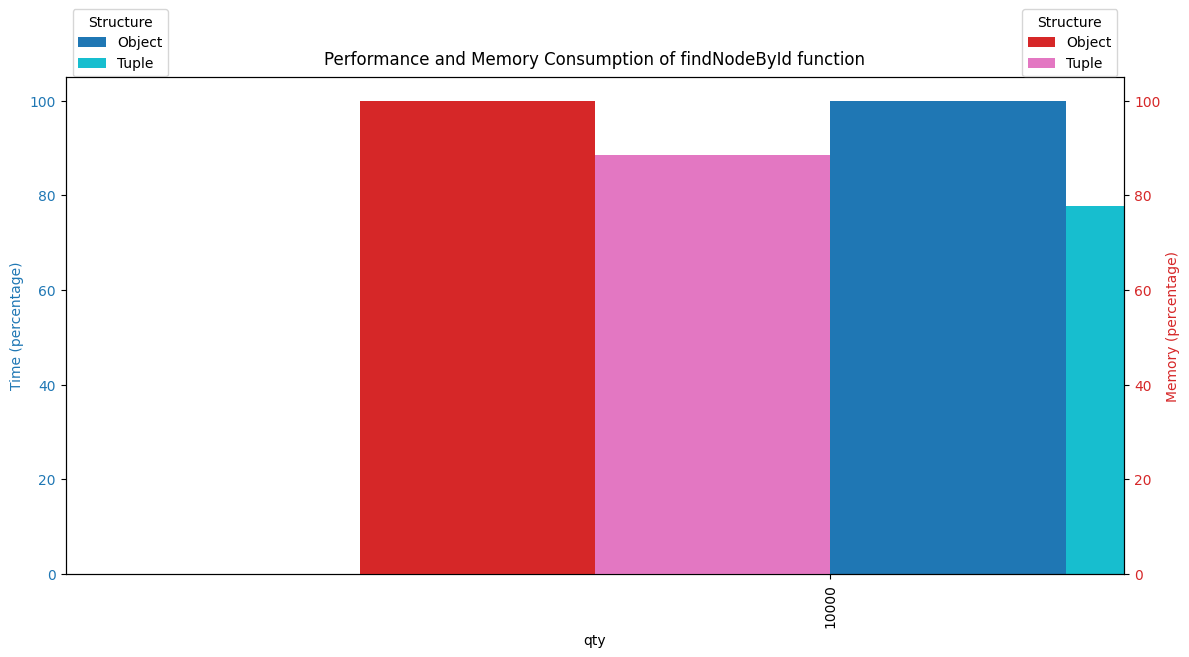

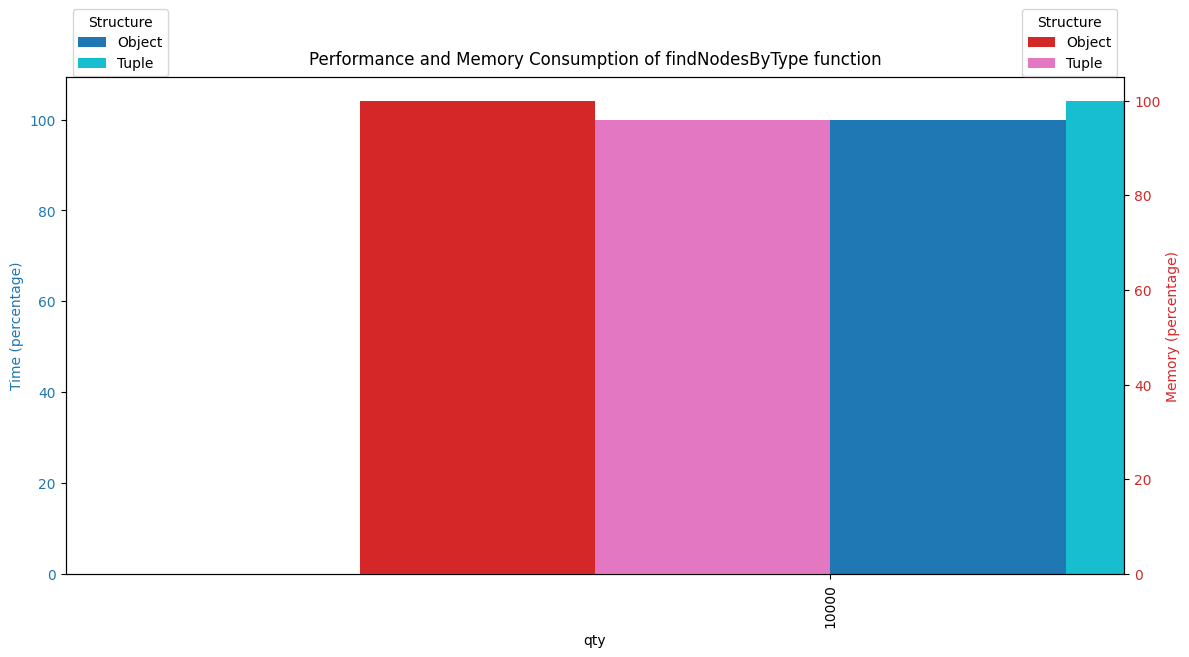

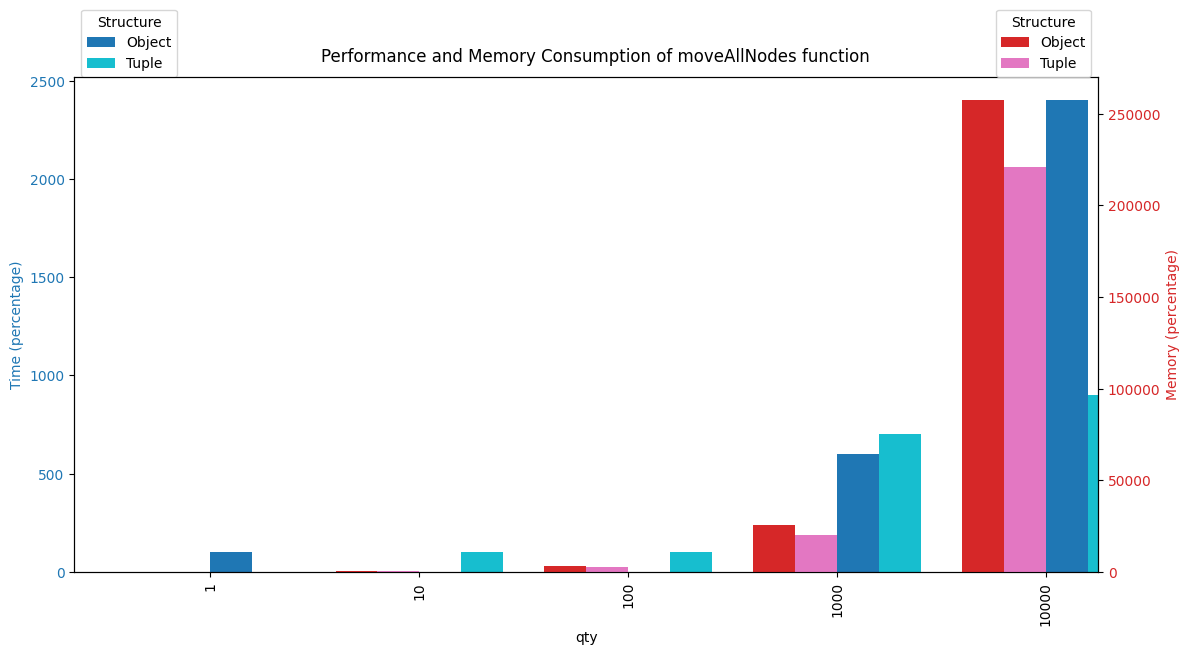

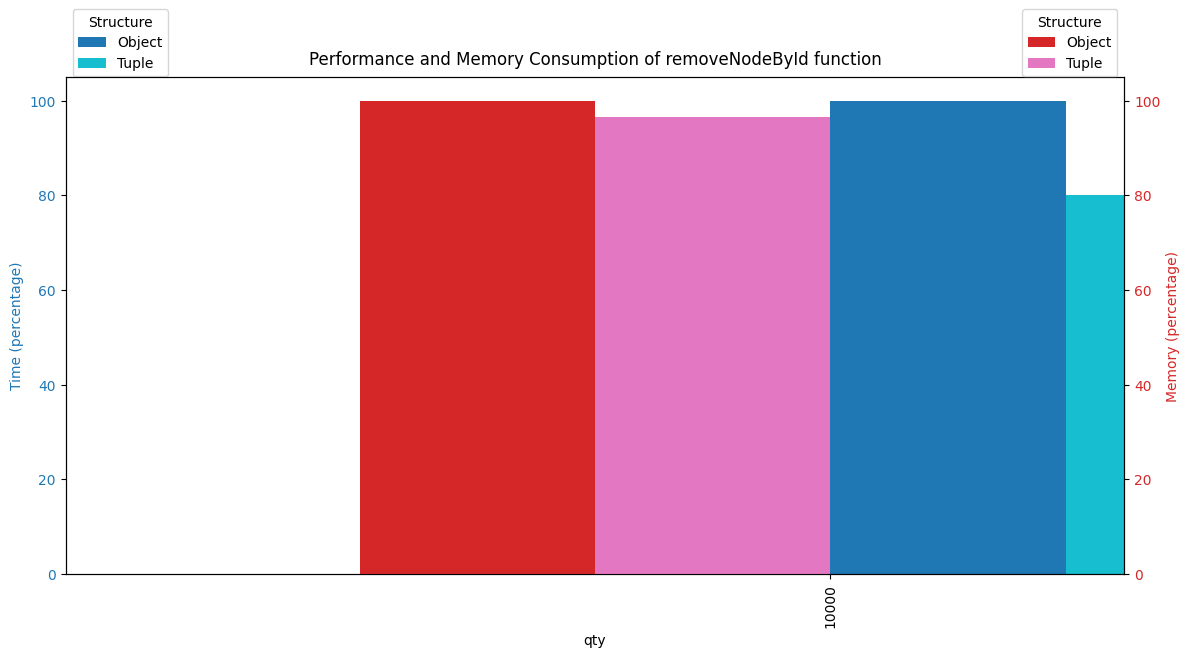

In [42]:
# Plotting the combined graphs
def plot_combined_graph(df, action):
    subset = df[df['action'] == action]
    pivot_time_df = subset.pivot(index='qty', columns='structure', values='time')
    pivot_memory_df = subset.pivot(index='qty', columns='structure', values='size')

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_xlabel('Quantity')
    ax1.set_ylabel('Time (percentage)', color='tab:blue')
    pivot_time_df.plot(kind='bar', ax=ax1, position=0, width=0.4, color=['tab:blue', 'tab:cyan'], legend=False)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Memory (percentage)', color='tab:red')
    pivot_memory_df.plot(kind='bar', ax=ax2, position=1, width=0.4, color=['tab:red', 'tab:pink'], legend=False)
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.tight_layout()
    fig.suptitle(f'Performance and Memory Consumption of {action} function', y=1.02)
    ax1.legend(loc='upper left', bbox_to_anchor=(0, 1.15), title='Structure')
    ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.15), title='Structure')

    plt.show()

# Plot combined graphs for each action
for action in merged_df['action'].unique():
    plot_combined_graph(merged_df, action)